In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import LSTM, Dense, Dropout, MultiHeadAttention, LayerNormalization


In [2]:
! pip install mplfinance
! pip install pandas_ta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=f8d705b959788c6f089ecb034f4b2a63d31a4b5bbcf66c3b6f1c934d66c80be3
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [3]:
data = pd.read_csv('/kaggle/input/eurusd/EURUSD-30-DS.csv', header=None, names=['Date','Open', 'High', 'Low', 'Close','Volume'])
data.head()

,Date,Open,High,Low,Close,Volume
0,01.01.2008 02:00:00.000,1.45841,1.45982,1.45770,1.45937,6473.2500
1,01.01.2008 02:30:00.000,1.45965,1.45982,1.45768,1.45785,6484.6000
2,01.01.2008 03:00:00.000,1.45788,1.45803,1.45761,1.45784,4957.6000
3,01.01.2008 03:30:00.000,1.45788,1.45794,1.45754,1.45770,3416.5500
4,01.01.2008 04:00:00.000,1.45770,1.45983,1.45766,1.45954,5553.4375


In [4]:
import pandas_ta as ta
data['RSI_14'] = ta.rsi(data['Close'], length=14)
data['MA20'] = ta.ema(data['Close'], length=20)
data['MACD'] = ta.macd(data['Close'])['MACD_12_26_9']
data['ATR_4'] = ta.atr(data['High'], data['Low'], data['Close'], length=4)
data['ATR_14'] = ta.atr(data['High'], data['Low'], data['Close'], length=14)
data['ATR_40'] = ta.atr(data['High'], data['Low'], data['Close'], length=40)
bb = ta.bbands(data['Close'], length=20)
data['BB_upper'] = bb['BBU_20_2.0']
data['BB_lower'] = bb['BBL_20_2.0']
data['Stoch_K'] = ta.stoch(data['High'], data['Low'], data['Close'])['STOCHk_14_3_3']
data['CCI_20'] = ta.cci(data['High'], data['Low'], data['Close'], length=20)
data['adx_14'] = data.ta.adx(length=14)['ADX_14']
data['Candle_Range'] = data['High'] - data['Low']
data['Candle_Body'] = data['Close'] - data['Open']


# # اضافه کردن لگ‌های زمانی برای Average
# for lag in range(1, 6):  # لگ‌های 1 تا 5
#     data[f'Average_Lag_{lag}'] = data['Average'].shift(lag)

data['Rolling_Mean_10'] = data['Close'].rolling(window=10).mean()
data['Rolling_Std_20'] = data['Close'].rolling(window=20).std()
data['Rolling_Max_20'] = data['High'].rolling(window=20).max()
data['Rolling_Min_20'] = data['Low'].rolling(window=20).min()
data['Price_Change'] = (data['Close'] - data['Open']) / data['Open']
data['Stoch_D'] = ta.stoch(data['High'], data['Low'], data['Close'])['STOCHd_14_3_3']
data = data.dropna()

data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y %H:%M:%S.%f')
data['Hour_of_Day'] = data['Date'].dt.hour
data['Day_of_Week'] = data['Date'].dt.dayofweek

data['Average'] = ((data['Open'] + data['Close'] + data['High'] + data['Low']) / 4)

data = data.dropna()

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
<ipython-input-4-a724bfea0254>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y %H:%M:%S.%f')
<ipython-input-4-a724bfea0254>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [5]:
data.head(7)

,Date,Open,High,Low,Close,Volume,RSI_14,MA20,MACD,ATR_4,...,Candle_Body,Rolling_Mean_10,Rolling_Std_20,Rolling_Max_20,Rolling_Min_20,Price_Change,Stoch_D,Hour_of_Day,Day_of_Week,Average
40,2008-01-01 22:00:00,1.45872,1.45971,1.45825,1.45926,7467.4220,52.258601,1.458901,-0.000026,0.001570,...,0.00054,1.459013,0.000718,1.46174,1.45718,0.000370,21.059847,22,1,1.458985
41,2008-01-01 22:30:00,1.45960,1.45973,1.45880,1.45938,9497.9875,53.027684,1.458946,0.000015,0.001410,...,-0.00022,1.459054,0.000727,1.46174,1.45718,-0.000151,26.245870,22,1,1.459377
42,2008-01-01 23:00:00,1.45933,1.46013,1.45820,1.45881,10169.0220,48.990588,1.458933,0.000002,0.001540,...,-0.00052,1.459060,0.000727,1.46174,1.45718,-0.000356,36.365550,23,1,1.459118
43,2008-01-01 23:30:00,1.45873,1.45919,1.45829,1.45903,14271.0000,50.555245,1.458943,0.000009,0.001380,...,0.00030,1.459073,0.000726,1.46174,1.45718,0.000206,41.739766,23,1,1.458810
44,2008-01-02 00:00:00,1.45910,1.45945,1.45835,1.45897,10793.2500,50.103853,1.458945,0.000009,0.001310,...,-0.00013,1.459086,0.000725,1.46174,1.45718,-0.000089,41.081871,0,2,1.458968
45,2008-01-02 00:30:00,1.45899,1.46112,1.45863,1.45917,13292.1845,51.653441,1.458967,0.000026,0.001605,...,0.00018,1.458914,0.000727,1.46174,1.45718,0.000123,40.399610,0,2,1.459478
46,2008-01-02 01:00:00,1.45906,1.46285,1.45895,1.46193,17232.9470,66.920893,1.459249,0.000259,0.002179,...,0.00287,1.459060,0.000979,1.46285,1.45718,0.001967,45.078231,1,2,1.460697


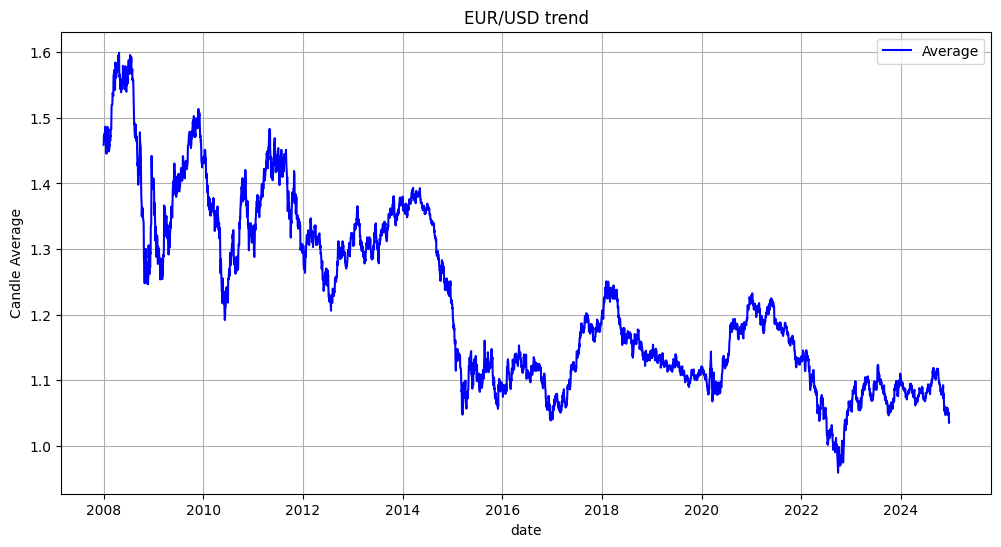

In [6]:
data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y %H:%M:%S.%f')
data['Day'] = data['Date'].dt.date
daily_data = data.groupby('Day').first().reset_index()  # اولین نمونه هر روز

# 4. رسم Line Plot برای Close
plt.figure(figsize=(12, 6))
plt.plot(daily_data['Date'], daily_data['Average'], label='Average', color='blue')

# 5. تنظیمات نمودار
plt.title('EUR/USD trend')
plt.xlabel('date')
plt.ylabel('Candle Average')
plt.legend()
plt.grid(True)

# 6. نمایش
plt.show()

In [6]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'RSI_14', 'MA20',
       'MACD', 'ATR_4', 'ATR_14', 'ATR_40', 'BB_upper', 'BB_lower', 'Stoch_K',
       'CCI_20', 'adx_14', 'Candle_Range', 'Candle_Body', 'Rolling_Mean_10',
       'Rolling_Std_20', 'Rolling_Max_20', 'Rolling_Min_20', 'Price_Change',
       'Stoch_D', 'Hour_of_Day', 'Day_of_Week', 'Average'],
      dtype='object')

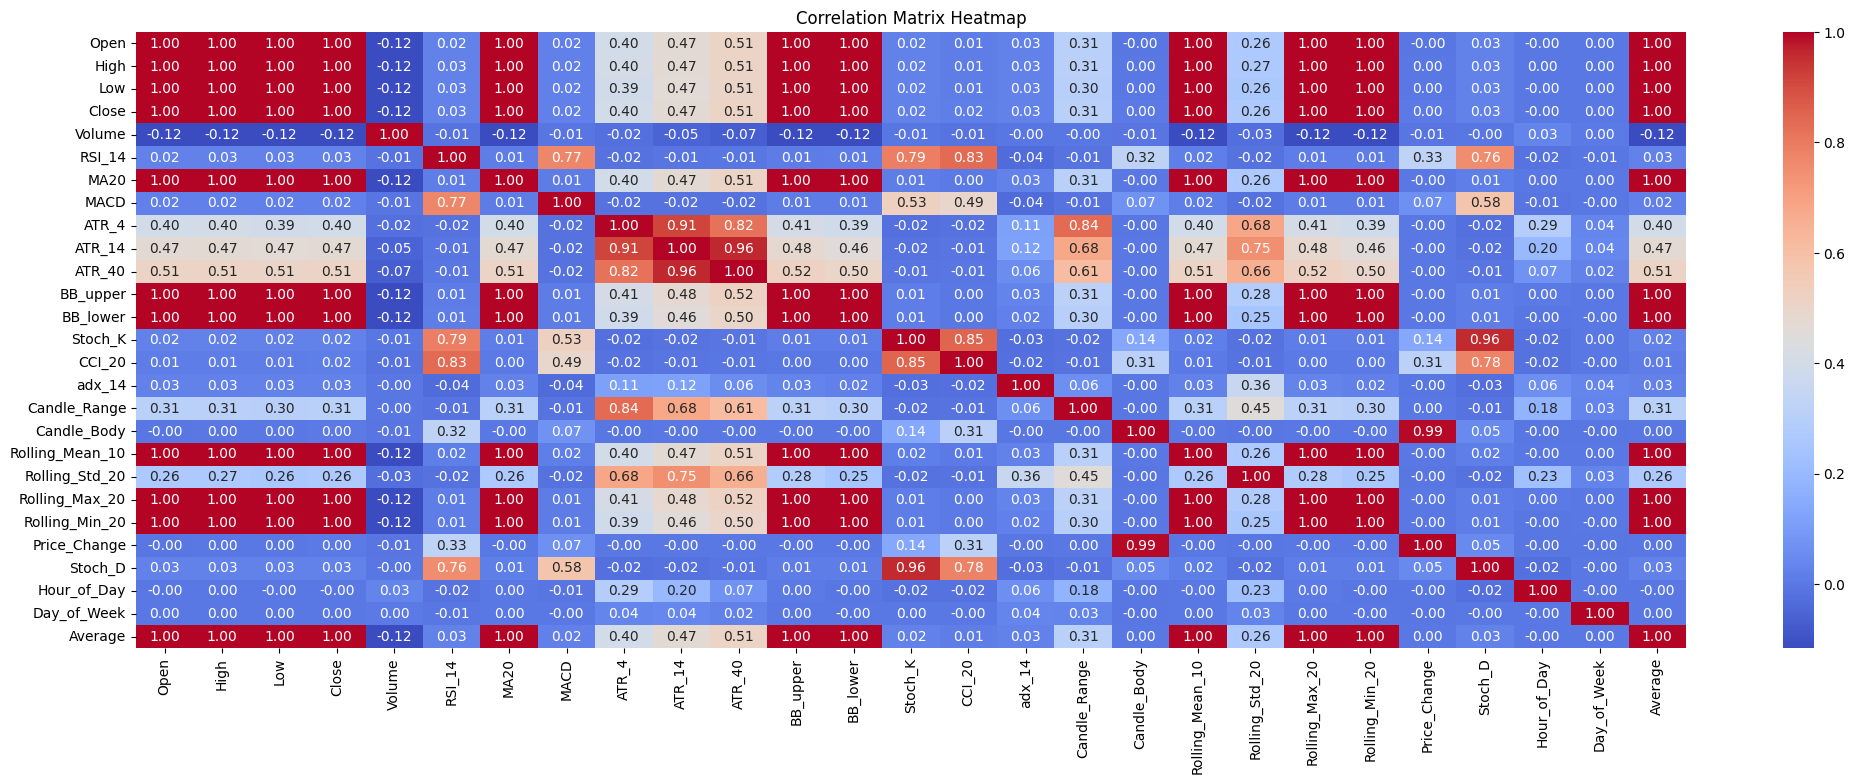

In [7]:
import seaborn as sns
correlation_matrix = data[['Open', 'High', 'Low', 'Close', 'Volume', 'RSI_14', 'MA20',
       'MACD', 'ATR_4', 'ATR_14', 'ATR_40', 'BB_upper', 'BB_lower', 'Stoch_K',
       'CCI_20', 'adx_14', 'Candle_Range', 'Candle_Body', 'Rolling_Mean_10',
       'Rolling_Std_20', 'Rolling_Max_20', 'Rolling_Min_20', 'Price_Change',
       'Stoch_D', 'Hour_of_Day', 'Day_of_Week', 'Average']].corr()
plt.figure(figsize=(25, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

In [5]:
input_features = ['RSI_14','MACD','MA20','ATR_40','BB_upper','Stoch_K','CCI_20','adx_14','Candle_Range','Rolling_Std_20','Average','Price_Change','Stoch_D','Hour_of_Day','Day_of_Week']
scalers_inputs = {col: MinMaxScaler() for col in input_features}
scaled_inputs = np.array([scalers_inputs[col].fit_transform(data[col].values.reshape(-1, 1)) for col in input_features])
scaled_inputs = np.transpose(scaled_inputs, (1, 0, 2))

# 3. انتخاب تارگت (OHLC)
output_features = ['Average']
scalers_outputs = {col: MinMaxScaler() for col in output_features}
scaled_outputs = np.array([scalers_outputs[col].fit_transform(data[col].values.reshape(-1, 1)) for col in output_features])
scaled_outputs = np.transpose(scaled_outputs, (1, 0, 2))

In [6]:
def create_sequences(inputs, outputs, seq_length):
    X, y = [], []
    for i in range(len(inputs) - seq_length):
        X.append(inputs[i:i + seq_length])
        y.append(outputs[i + seq_length])  # 4 مقدار OHLC تایم‌فریم بعدی
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(scaled_inputs, scaled_outputs, seq_length)

In [7]:
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

print("تعداد نمونه‌های Train:", len(X_train))
print("تعداد نمونه‌های Validation:", len(X_val))
print("تعداد نمونه‌های Test:", len(X_test))

تعداد نمونه‌های Train: 169480
تعداد نمونه‌های Validation: 21185
تعداد نمونه‌های Test: 21186


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import numpy as np

inputs = Input(shape=(seq_length, len(input_features)))

# لایه‌های LSTM
x = LSTM(100, return_sequences=True)(inputs)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = LSTM(100, return_sequences=True)(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = LSTM(75, return_sequences=True)(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = LSTM(50, return_sequences=True)(x)
x = Dropout(0.4)(x)


x = MultiHeadAttention(num_heads=4, key_dim=50)(x, x, x)

# لایه‌های Dense
x = tf.keras.layers.GlobalAveragePooling1D()(x)  # تبدیل سکانس به بردار
x = Dense(25, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
outputs = Dense(1)(x)

# تعریف مدل
model = Model(inputs=inputs, outputs=outputs)

# تعریف optimizer
optimizer = Adam(learning_rate=0.0005)

# کامپایل مدل
model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])


def lr_scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)  # مطمئن می‌شیم که lr یه float باشه
    else:
        return float(lr * np.exp(-0.1))  # از np.exp استفاده می‌کنیم

lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

# تعریف EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# نمایش خلاصه مدل
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 30, 15)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 30, 100)        │         46,400 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 30, 100)        │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 30, 100)        │            400 │ dropout[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 30, 100)        │         80,400 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 30, 100)        │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 30, 100)        │            400 │ dropout_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 30, 75)         │         52,800 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 30, 75)         │              0 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 30, 75)         │            300 │ dropout_2[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 30, 50)         │         25,200 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 30, 50)         │              0 │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 30, 50)         │         40,650 │ dropout_3[0][0],       │
│ (MultiHeadAttention)      │                        │                │ dropout_3[0][0],       │
│                           │                        │                │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 50)             │              0 │ multi_head_attention[… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 25)             │          1,275 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 10)             │            260 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)      

 Total params: 248,096 (969.12 KB)

 Trainable params: 247,546 (966.98 KB)

 Non-trainable params: 550 (2.15 KB)

In [9]:
# آموزش مدل
history = model.fit(
    X_train, y_train,
    epochs=70,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, lr_scheduler_callback],
    verbose=1
)

Epoch 1/70
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 87s 15ms/step - loss: 0.1393 - mae: 0.0345 - val_loss: 0.0341 - val_mae: 0.0297 - learning_rate: 5.0000e-04
Epoch 2/70
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 77s 15ms/step - loss: 0.0129 - mae: 0.0095 - val_loss: 0.0235 - val_mae: 0.0218 - learning_rate: 5.0000e-04
Epoch 3/70
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 78s 15ms/step - loss: 0.0085 - mae: 0.0070 - val_loss: 0.0159 - val_mae: 0.0149 - learning_rate: 5.0000e-04
Epoch 4/70
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 78s 15ms/step - loss: 0.0072 - mae: 0.0062 - val_loss: 0.0175 - val_mae: 0.0168 - learning_rate: 5.0000e-04
Epoch 5/70
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 78s 15ms/step - loss: 0.0060 - mae: 0.0053 - val_loss: 0.0140 - val_mae: 0.0134 - learning_rate: 5.0000e-04
Epoch 6/70
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 78s 15ms/step - loss: 0.0055 - mae: 0.0049 - val_loss: 0.0167 - val_mae: 0.0162 - learning_rate: 5.0000e-04
Epoch 7/70
5297/5297 ━━━━━━━━━━━━━━━━━━━━ 78s 15ms/step - loss: 0.0051 - mae: 0.0046 - val_loss: 0.0

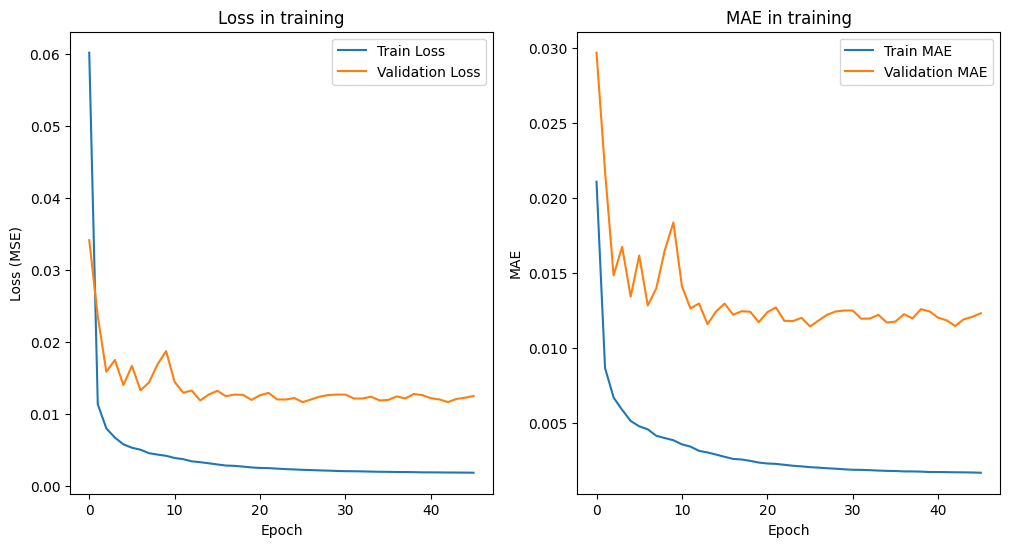

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss in training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE in training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

663/663 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

معیارهای ارزیابی برای Average:
MSE: 5.879399111621434e-07
RMSE: 0.000766772398539582
MAE: 0.0004972069724450361
R² Score: 0.9979160763757957


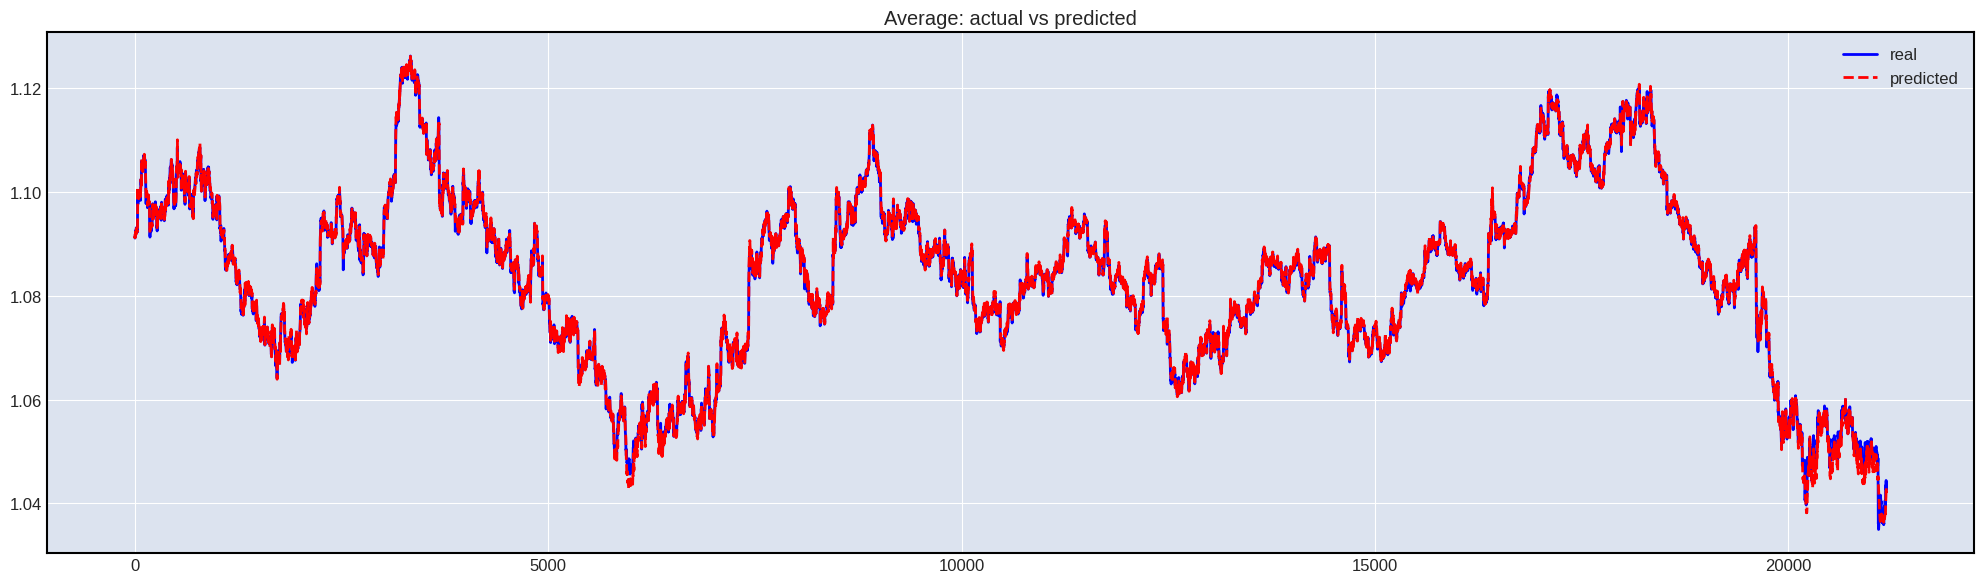

In [22]:
predictions = model.predict(X_test)

# 10. برگردوندن به مقیاس اصلی
predictions_average = scalers_outputs['Average'].inverse_transform(predictions[:, 0].reshape(-1, 1))


y_test_average = scalers_outputs['Average'].inverse_transform(y_test[:, 0].reshape(-1, 1))

# 11. محاسبه معیارها برای هر مقدار
def calculate_metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\nمعیارهای ارزیابی برای {name}:")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R² Score: {r2}")

calculate_metrics(y_test_average, predictions_average, "Average")



# 13. رسم پیش‌بینی‌ها
plt.figure(figsize=(20, 6))
plt.subplot(1, 1, 1)
plt.plot(y_test_average, label='real', color='blue')
plt.plot(predictions_average, label='predicted', color='red',linestyle='--')
plt.title('Average: actual vs predicted')
plt.legend()



plt.tight_layout()
plt.show()

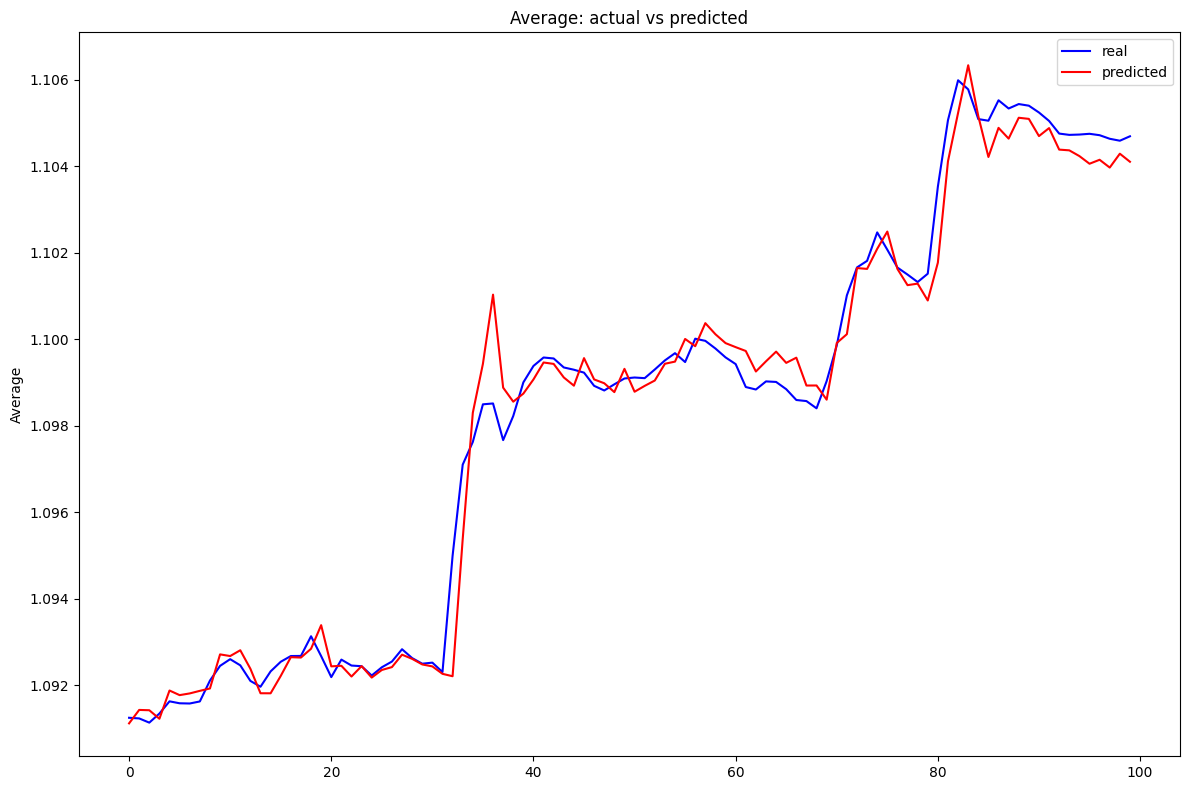

In [12]:
n_samples = 100  # تعداد نمونه‌هایی که می‌خوای نشون بدی

plt.figure(figsize=(12, 8))
plt.subplot(1, 1, 1)
plt.plot(y_test_average[:n_samples], label='real', color='blue')
plt.plot(predictions_average[:n_samples], label='predicted', color='red')
plt.title('Average: actual vs predicted')
plt.ylabel('Average')
plt.legend()



plt.tight_layout()
plt.show()

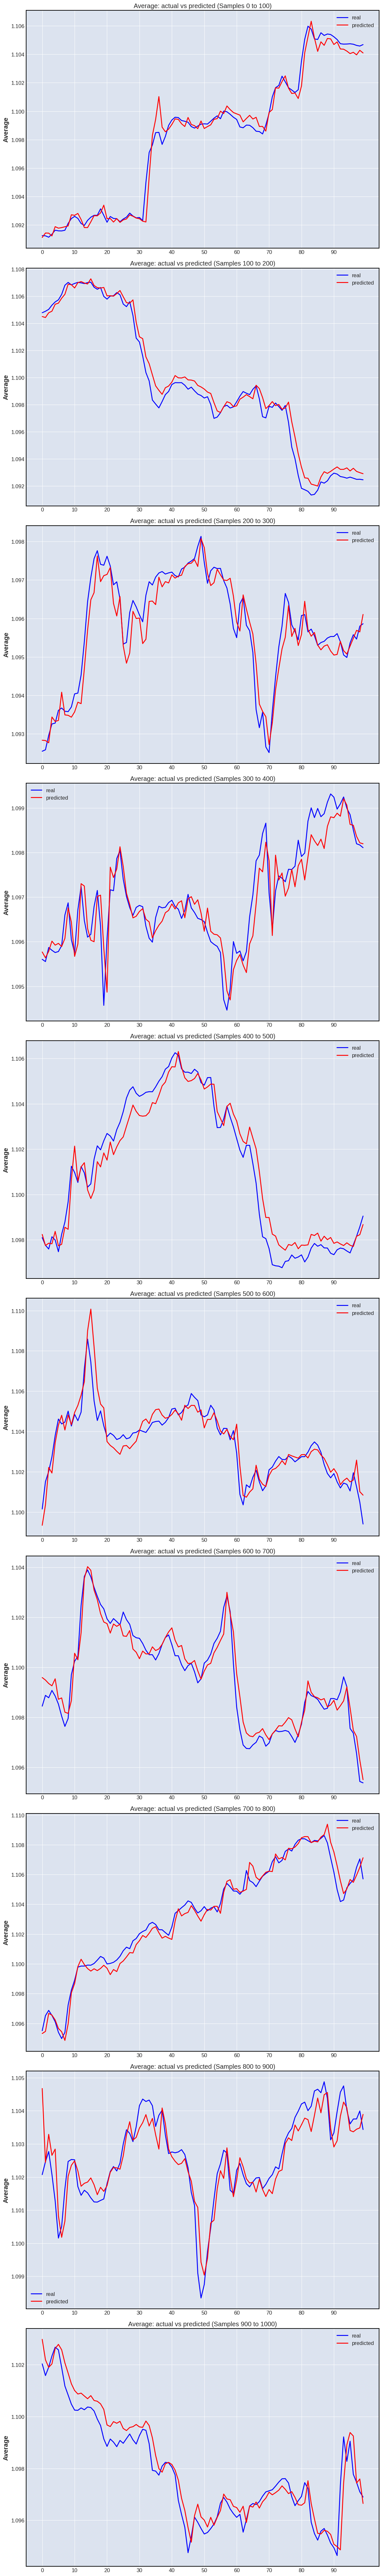

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# فرض می‌کنیم y_test_average و predictions_average آرایه‌های شما هستن
# y_test_average: مقادیر واقعی Average برای داده‌های تست
# predictions_average: مقادیر پیش‌بینی‌شده Average توسط مدل

# تعداد نمونه‌هایی که می‌خوای رسم کنی (1000 نمونه اول)
total_samples = 1000
n_samples_per_plot = 100  # تعداد نمونه‌ها در هر نمودار
n_plots = total_samples // n_samples_per_plot  # تعداد نمودارها (10)

# تنظیمات شکل کلی
plt.figure(figsize=(12, 8 * n_plots))  # ارتفاع شکل رو متناسب با تعداد نمودارها تنظیم می‌کنیم

# حلقه برای رسم 10 نمودار
for i in range(n_plots):
    # محاسبه بازه نمونه‌ها برای هر نمودار
    start_idx = i * n_samples_per_plot
    end_idx = (i + 1) * n_samples_per_plot
    
    # انتخاب داده‌ها برای این بازه
    y_test_subset = y_test_average[start_idx:end_idx]
    predictions_subset = predictions_average[start_idx:end_idx]
    
    # ایجاد زیرنمودار
    plt.subplot(n_plots, 1, i + 1)  # n_plots ردیف، 1 ستون، اندیس i+1
    
    # رسم خطوط
    plt.plot(y_test_subset, label='real', color='blue')
    plt.plot(predictions_subset, label='predicted', color='red')
    
    # اضافه کردن عنوان و لیبل‌ها
    plt.title(f'Average: actual vs predicted (Samples {start_idx} to {end_idx})')
    plt.ylabel('Average')
    plt.legend()
    
    # تنظیم محور x برای نمایش اندیس نمونه‌ها
    plt.xticks(np.arange(0, n_samples_per_plot, 10))  # تیک‌ها هر 10 نمونه

# تنظیمات نهایی و نمایش نمودار
plt.tight_layout()
plt.show()

MAE on Test Data: 0.059806942790222174
RMSE on Test Data: 0.06004266521400436


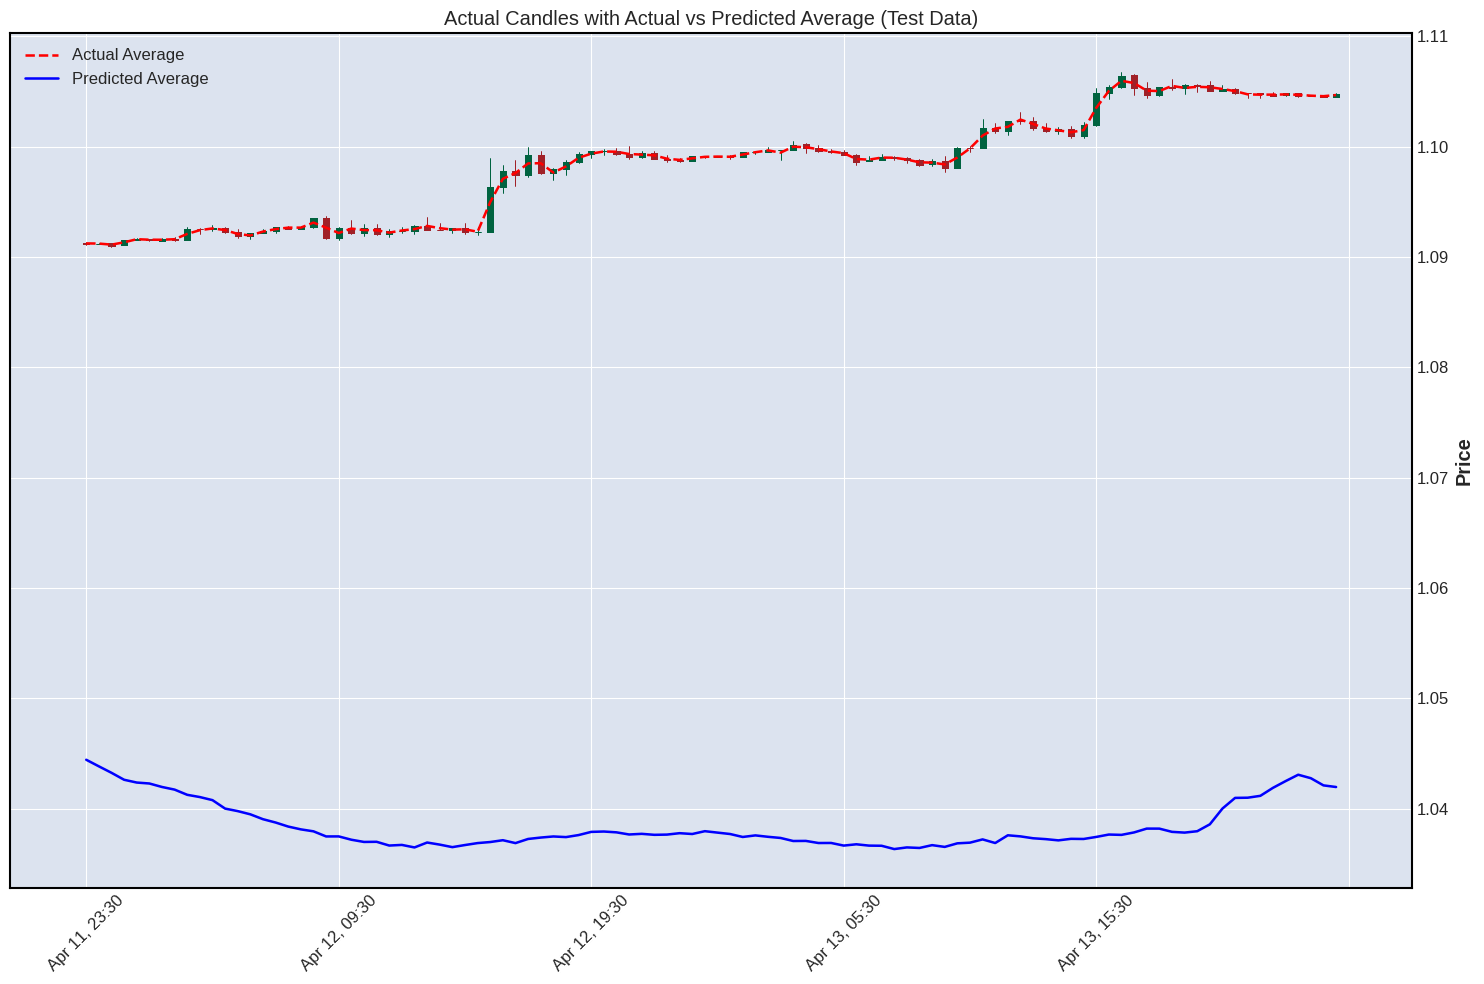

In [19]:
import mplfinance as mpf
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# فرض می‌کنیم data دیتافریم اولیه شماست که ستون‌های Date, Open, High, Low, Close, Average داره
# تبدیل ستون Date به فرمت datetime
data['Date'] = pd.to_datetime(data['Date'], format='mixed', dayfirst=True)

# تعداد نمونه‌های تست رو از X_test می‌گیریم
n_test_samples = len(X_test)  # تعداد نمونه‌های تست: 21186

# انتخاب داده‌های تست از دیتافریم data
# چون X_test از داده‌های سکانس‌دار ساخته شده، باید seq_length رو در نظر بگیریم
# X_test از اندیس (N - seq_length - n_test_samples) تا (N - seq_length) توی datacorrespond می‌کنه
test_data = data.iloc[-n_test_samples:].copy()
test_data.set_index('Date', inplace=True)
test_data.index = pd.DatetimeIndex(test_data.index)

# محدود کردن تعداد نمونه‌ها برای رسم (مثلاً 1000 نمونه آخر)
n_samples_to_plot = 100
test_data = test_data.iloc[-n_samples_to_plot:]

# فرض می‌کنیم predictions خروجی مدل شماست و برای داده‌های تست (X_test) هست
# predictions باید ابعاد (n_test_samples, 1) داشته باشه
predicted_average = predictions.flatten()  # تبدیل به آرایه یک‌بعدی
predicted_average = predicted_average[-n_samples_to_plot:]  # محدود کردن به 1000 نمونه آخر

# اگه predictions نرمال‌سازی‌شده هست، باید به مقیاس اصلی برگردونیم
# فرض می‌کنیم scalers_outputs['Average'] همون اسکیلری هست که برای نرمال‌سازی Average استفاده کردی
predicted_average = scalers_outputs['Average'].inverse_transform(predicted_average.reshape(-1, 1)).flatten()

# ایجاد یک DataFrame برای Average پیش‌بینی‌شده با همان ایندکس
predicted_df = pd.DataFrame({
    'Predicted_Average': predicted_average
}, index=test_data.index)

# برای مقایسه، Average واقعی رو هم از test_data می‌گیریم
actual_average = test_data['Average'].values
actual_average_df = pd.DataFrame({
    'Actual_Average': actual_average
}, index=test_data.index)

# محاسبه معیارهای ارزیابی
mae = mean_absolute_error(actual_average, predicted_average)
rmse = np.sqrt(mean_squared_error(actual_average, predicted_average))
print(f"MAE on Test Data: {mae}")
print(f"RMSE on Test Data: {rmse}")

# تنظیمات برای رسم
fig = mpf.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)

# رسم کندل‌استیک‌ها
mpf.plot(test_data, type='candle', style='charles', ax=ax, volume=False)

# اضافه کردن خط Actual Average
ap1 = mpf.make_addplot(actual_average_df['Actual_Average'], type='line', color='red', linestyle='--',  ax=ax, label='Actual Average')

# اضافه کردن خط Predicted Average
ap2 = mpf.make_addplot(predicted_df['Predicted_Average'], type='line', color='blue', linestyle='-',  ax=ax, label='Predicted Average')

# رسم کندل‌ها با هر دو خط
mpf.plot(test_data, type='candle', style='charles', ax=ax, volume=False, addplot=[ap1, ap2])

# اضافه کردن عنوان و لیبل‌ها
ax.set_title('Actual Candles with Actual vs Predicted Average (Test Data)')
ax.set_ylabel('Price')

# نمایش لجند
ax.legend()

# تنظیمات نهایی و نمایش نمودار
fig.tight_layout()
mpf.show()

MAE on Test Data (First 100 Samples): 0.00041716120605468144
RMSE on Test Data (First 100 Samples): 0.0006151133035821136


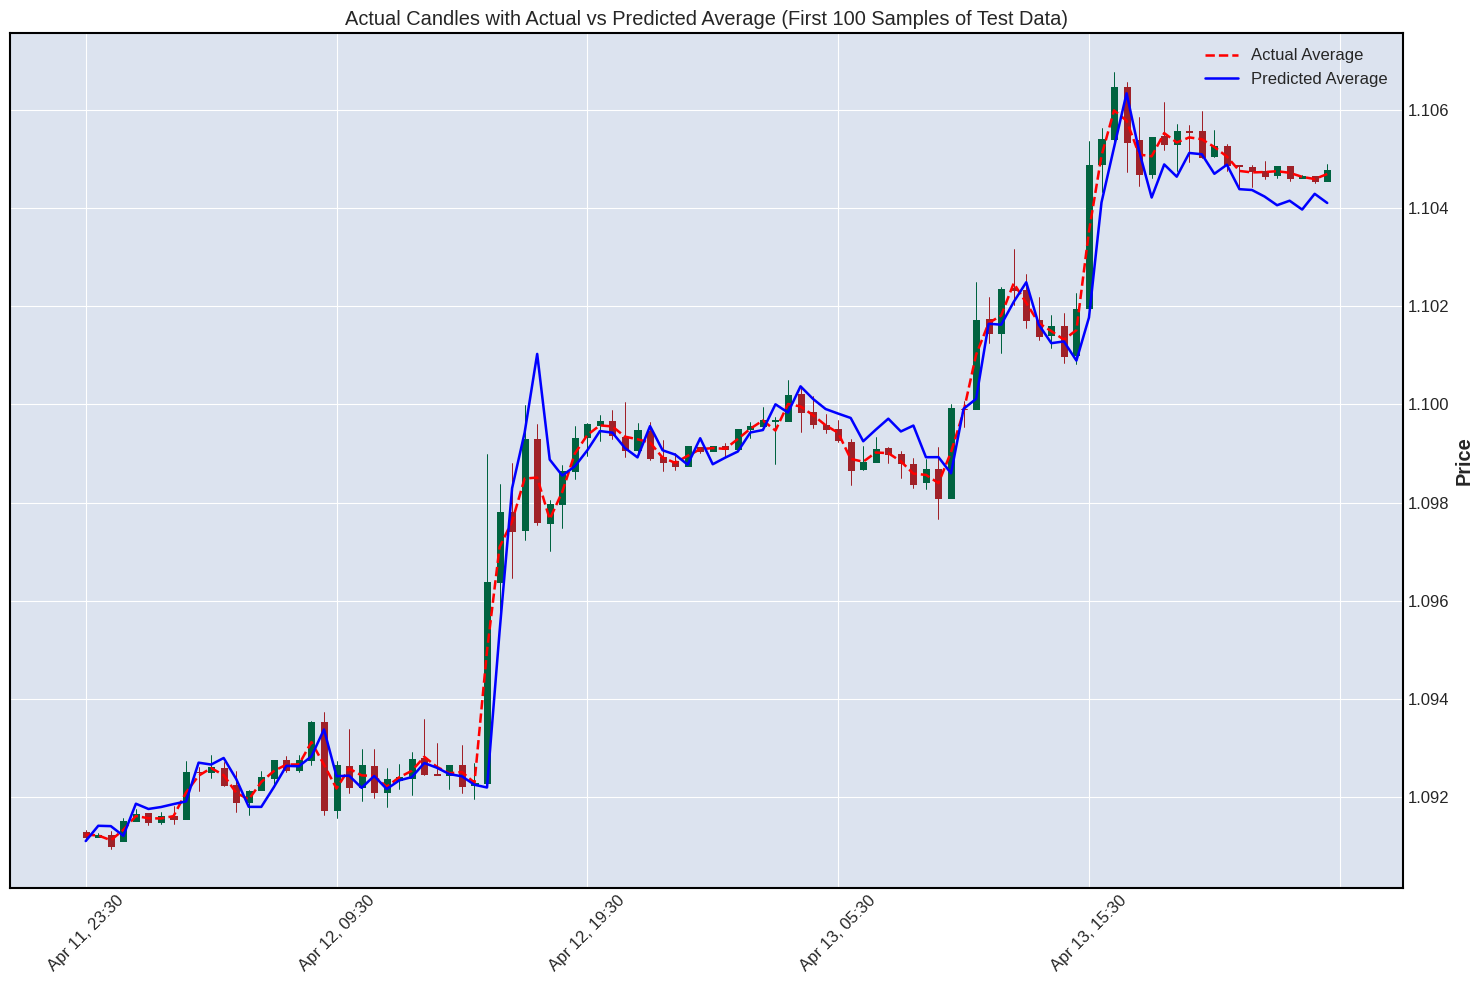

In [20]:
import mplfinance as mpf
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# فرض می‌کنیم data دیتافریم اولیه شماست که ستون‌های Date, Open, High, Low, Close, Average داره
# تبدیل ستون Date به فرمت datetime
data['Date'] = pd.to_datetime(data['Date'], format='mixed', dayfirst=True)

# تعداد نمونه‌های تست رو از X_test می‌گیریم
n_test_samples = len(X_test)  # تعداد نمونه‌های تست: 21186

# انتخاب داده‌های تست از دیتافریم data
test_data = data.iloc[-n_test_samples:].copy()
test_data.set_index('Date', inplace=True)
test_data.index = pd.DatetimeIndex(test_data.index)

# محدود کردن تعداد نمونه‌ها برای رسم (100 نمونه اول)
n_samples_to_plot = 100
test_data = test_data.iloc[:n_samples_to_plot]  # 100 نمونه اول

# فرض می‌کنیم predictions خروجی مدل شماست و برای داده‌های تست (X_test) هست
# predictions باید ابعاد (n_test_samples, 1) داشته باشه
predicted_average = predictions.flatten()  # تبدیل به آرایه یک‌بعدی
predicted_average = predicted_average[:n_samples_to_plot]  # محدود کردن به 100 نمونه اول

# اگه predictions نرمال‌سازی‌شده هست، باید به مقیاس اصلی برگردونیم
# فرض می‌کنیم scalers_outputs['Average'] همون اسکیلری هست که برای نرمال‌سازی Average استفاده کردی
predicted_average = scalers_outputs['Average'].inverse_transform(predicted_average.reshape(-1, 1)).flatten()

# ایجاد یک DataFrame برای Average پیش‌بینی‌شده با همان ایندکس
predicted_df = pd.DataFrame({
    'Predicted_Average': predicted_average
}, index=test_data.index)

# برای مقایسه، Average واقعی رو هم از test_data می‌گیریم
actual_average = test_data['Average'].values
actual_average_df = pd.DataFrame({
    'Actual_Average': actual_average
}, index=test_data.index)

# محاسبه معیارهای ارزیابی
mae = mean_absolute_error(actual_average, predicted_average)
rmse = np.sqrt(mean_squared_error(actual_average, predicted_average))
print(f"MAE on Test Data (First 100 Samples): {mae}")
print(f"RMSE on Test Data (First 100 Samples): {rmse}")

# تنظیمات برای رسم
fig = mpf.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)

# رسم کندل‌استیک‌ها
mpf.plot(test_data, type='candle', style='charles', ax=ax, volume=False)

# اضافه کردن خط Actual Average
ap1 = mpf.make_addplot(actual_average_df['Actual_Average'], type='line', color='red', linestyle='--', ax=ax, label='Actual Average')

# اضافه کردن خط Predicted Average
ap2 = mpf.make_addplot(predicted_df['Predicted_Average'], type='line', color='blue', linestyle='-',  ax=ax, label='Predicted Average')

# رسم کندل‌ها با هر دو خط
mpf.plot(test_data, type='candle', style='charles', ax=ax, volume=False, addplot=[ap1, ap2])

# اضافه کردن عنوان و لیبل‌ها
ax.set_title('Actual Candles with Actual vs Predicted Average (First 100 Samples of Test Data)')
ax.set_ylabel('Price')

# نمایش لجند
ax.legend()

# تنظیمات نهایی و نمایش نمودار
fig.tight_layout()
mpf.show()